In [31]:
import matplotlib.pyplot as plt         # import matplotlib
from matplotlib.widgets import Slider
import numpy as np                      # import numpy
import ipywidgets as widgets            # interactive display
import warnings
warnings.filterwarnings("ignore")

# setting for figures
fig_w, fig_h = 8, 6
my_fontsize = 18
my_params = {'axes.labelsize': my_fontsize,
          'axes.titlesize': my_fontsize,
          'figure.figsize': (fig_w, fig_h),
          'font.size': my_fontsize,
          'legend.fontsize': my_fontsize-4,
          'lines.markersize': 8.,
          'lines.linewidth': 2.,
          'xtick.labelsize': my_fontsize-2,
          'ytick.labelsize': my_fontsize-2}

plt.rcParams.update(my_params)
my_layout = widgets.Layout()

# Auto Reloading
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Firing patterns of single neuron

interactive(children=(FloatSlider(value=20.0, description='tau_m', max=20.0, min=5.0, step=1.0), FloatSlider(v…

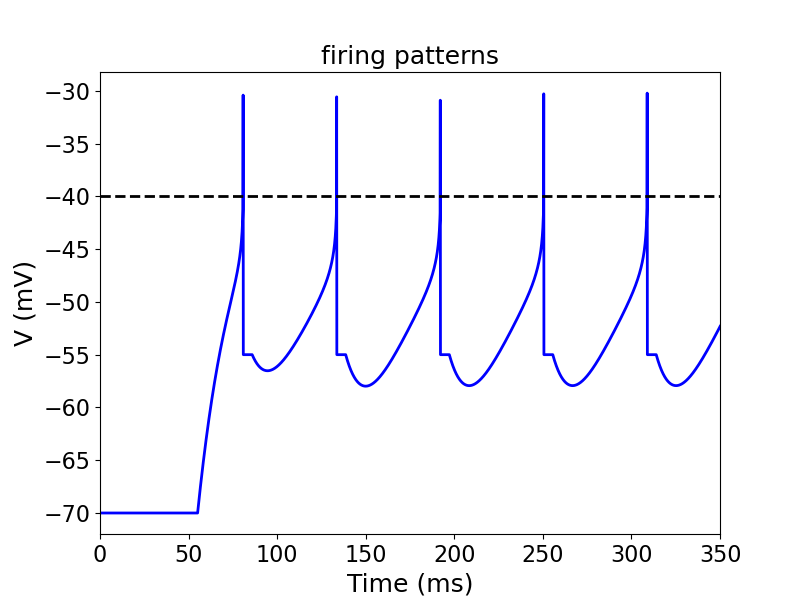

In [32]:
from lib.neuron import LIF
from lib.input import Poisson_generator, Gaussian_generator, Current_injector
from lib.conn import Simulator
from lib.helper import plot_volt_trace

T, dt = 5e2, 0.1    # simulation period(ms), step size(ms)
wt, dl = 1., 5.
rt = 65.

# simualtor
h = Simulator(dt=dt)

# neurons
nrn = LIF(sim=h)
nrn.g_L = 2.
nrn.E_L = -70.
nrn.V_th = -40.

# tonic
nrn.tau_m = 20.
nrn.tau_w = 30.
nrn.b = 3
nrn.V_reset = -55.

# # adpating
# nrn.tau_m = 20.
# nrn.tau_w = 100.
# nrn.b = 0.5
# nrn.V_reset = -55.

# # initial bursting
# nrn.tau_m = 10.
# nrn.tau_w = 100.
# nrn.b = 1.
# nrn.V_reset = -50.

# # bursting
# nrn.tau_m = 5.
# nrn.tau_w = 100.
# nrn.b = 1
# nrn.V_reset = -46.

# # irregular
# nrn.tau_m = 10.0
# nrn.a = -0.01
# nrn.tau_w = 50.
# nrn.b = 1.7
# nrn.V_reset = -46.

# # transient
# nrn.tau_m = 5.
# nrn.a = 0.05
# nrn.tau_w = 100.
# nrn.b = 0.7
# nrn.V_reset = -60.

# # delayed
# nrn.tau_m = 5.
# nrn.a = -0.1
# nrn.tau_w = 100.
# nrn.b = 1.0
# nrn.V_reset = -60.
# rt = 5.

# constant current injection
cur_in = Current_injector(sim=h, Is=np.concatenate([np.zeros(int(T/dt*0.1)), rt*np.ones(int(T/dt*0.9))]))
nrn.connect(cur_in, {'ctype':'static', 'weight': wt, 'delay':dl})

# updating parameters
def update(tau_m=20., a=0., tau_w=30., b=3., V_reset=-55., Icur=65.):
    # update value
    nrn.tau_m = tau_m
    nrn.a = a
    nrn.tau_w = tau_w
    nrn.b = b
    nrn.V_reset = V_reset

    cur_in.Is = np.concatenate([np.zeros(int(T/dt*0.1)), Icur*np.ones(int(T/dt*0.9))])

    # simulate
    h.run(T)

    # visualize
    plt.clf()
    plt.title('firing patterns')
    plt_par = {'dt':dt, 'range_t':np.arange(0., T, dt), 'V_th':nrn.V_th}
    plot_volt_trace(plt_par, nrn.v, np.array(nrn.spikes['times']))
    plt.xlim([0, 350])

fig = plt.figure()
widgets.interact(update, tau_m=(5.0, 20.0, 1.0), a=(-0.1, 0.1, 0.01), tau_w=(30., 120., 10.), b=(0., 3., 0.1), V_reset=(-60., -40., 2.), Icur=(5., 70., 5.));

### Set up your own neuron parameters

In [33]:
my_neuron = {'tau_m':20.0, 'a':0.0, 'tau_w':30.0, 'b':3.0, 'V_reset':-55.0}

### Functional neural motifs

![EI motif](figs/motifs.png "EI motif")

interactive(children=(FloatSlider(value=0.0, description='J_ei', max=0.0, min=-50.0, step=5.0), FloatSlider(va…

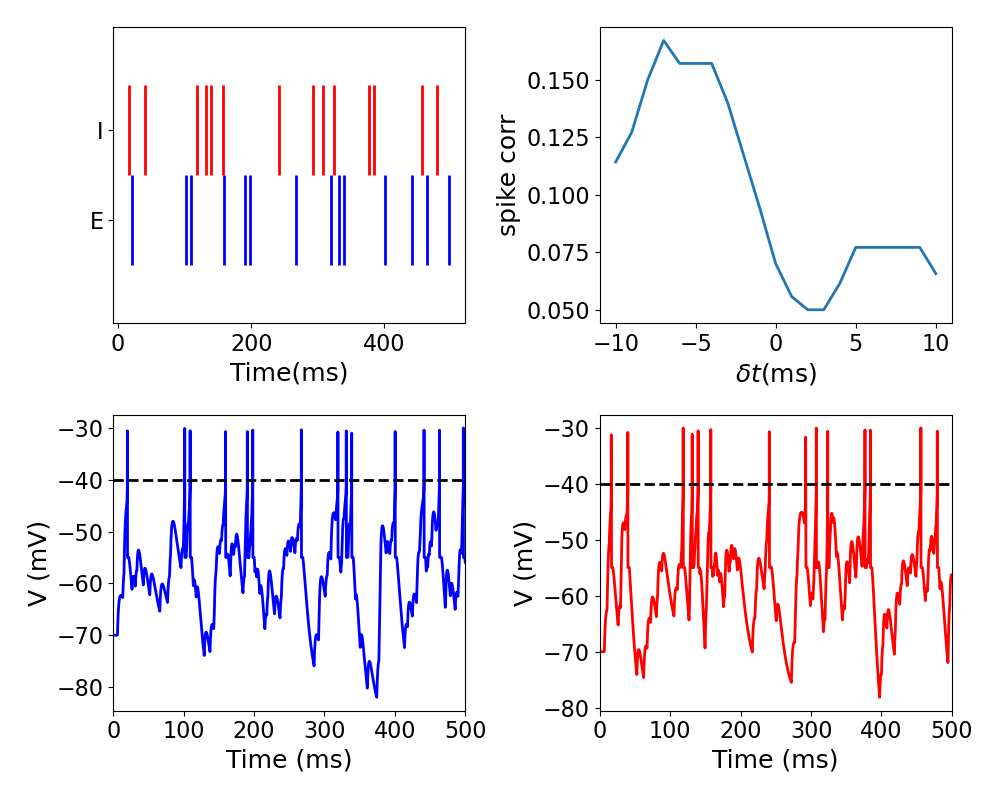

In [48]:
# E-I motif
N = 2                  # number of neurons
wt, dl = 1, 5.

# updating parameters
def update(J_ei=0., J_ie=0.):
    # simualtor
    h = Simulator(dt=dt)

    # network of neurons
    nrns = [LIF(sim=h) for _ in range(N)]

    for nrn in nrns:
        # my own neuron
        nrn.update(my_neuron)

    # background noise
    # noises = [Current_injector(sim=h, Is=np.concatenate([np.zeros(int(T/dt*0.1)), rt*np.ones(int(T/dt*0.9))])) for _ in range(N)]
    # noises = [Gaussian_generator(sim=h, mean=rt, std=rt) for _ in range(N)]
    noises = [Poisson_generator(sim=h, rate=250) for _ in range(N)]
    for noise, nrn in zip(noises, nrns):
        nrn.connect(noise, {'ctype':'static', 'weight':wt, 'delay':dl})

    # recurrent connections
    # tps = [['facilitate']*N]*N
    tps = [['static']*N]*N
    con = np.array([[0., J_ei],
                    [J_ie, 0.]])
    dly = np.random.uniform(2., 5., (N,N))
    synspecs = [[{} for _ in range(N)] for _ in range(N)]
    for i in range(N):
        for j in range(N):
            synspecs[i][j] = {'ctype':tps[i][j], 'weight':con[i,j], 'delay':dly[i,j]}
    h.connect(nrns, nrns, synspecs)

    # simulation
    h.run(T)

    # # extract data
    # bints = np.arange(0, T+1, 20.)
    # psths = [np.histogram(nrn.spikes['times'], bins=bints)[0] for nrn in nrns]

    # coincidence
    binwindow = int(5.0/dt)
    spike_trains = [nrn.states for nrn in nrns]
    bin_spikes = [np.convolve(strain, np.ones(binwindow), 'same') for strain in spike_trains]
    deltats = np.linspace(-10., 10., 21)
    coins = []
    for delay in deltats:
        index = int(delay/dt)
        if index > 0:
            coins.append(np.dot(bin_spikes[0][:-index], bin_spikes[1][index:]))
        elif index < 0:
            coins.append(np.dot(bin_spikes[1][:index], bin_spikes[0][-index:]))
        else:
            coins.append(np.dot(bin_spikes[0], bin_spikes[1]))
    coins = np.array(coins)/np.sqrt(np.dot(bin_spikes[0], bin_spikes[0]))/np.sqrt(np.dot(bin_spikes[1], bin_spikes[1]))

    # visualize
    plt.clf()
    cs = ['b', 'r']
    plt.subplot(2,N,1)
    for nrn, c, l in zip(nrns, cs, range(N)):
        plt.eventplot(nrn.spikes['times'], lineoffsets=l, colors=c)
    plt.xlabel('Time(ms)')
    plt.yticks([0, 1], ['E', 'I'])

    plt.subplot(2,N,2)
    plt.plot(deltats, coins)
    plt.xlabel(r'$\delta t$(ms)')
    plt.ylabel('spike corr')

    # voltage trace
    for id, c in zip(range(N), cs):
        plt.subplot(2,N,id+N+1)
        plt_par = {'dt':dt, 'range_t':np.arange(0., T, dt), 'V_th':nrns[id].V_th}
        plot_volt_trace(plt_par, nrns[id].v, np.array(nrns[id].spikes['times']), c=c)
        plt.xlim([0., T])

    plt.tight_layout()

plt.subplots(2,N,figsize=(5*N,8))
widgets.interact(update, J_ie=(0.0, 50.0, 5.0), J_ei=(-50., 0., 5));

interactive(children=(FloatSlider(value=0.0, description='J_1', max=0.0, min=-50.0, step=10.0), FloatSlider(va…

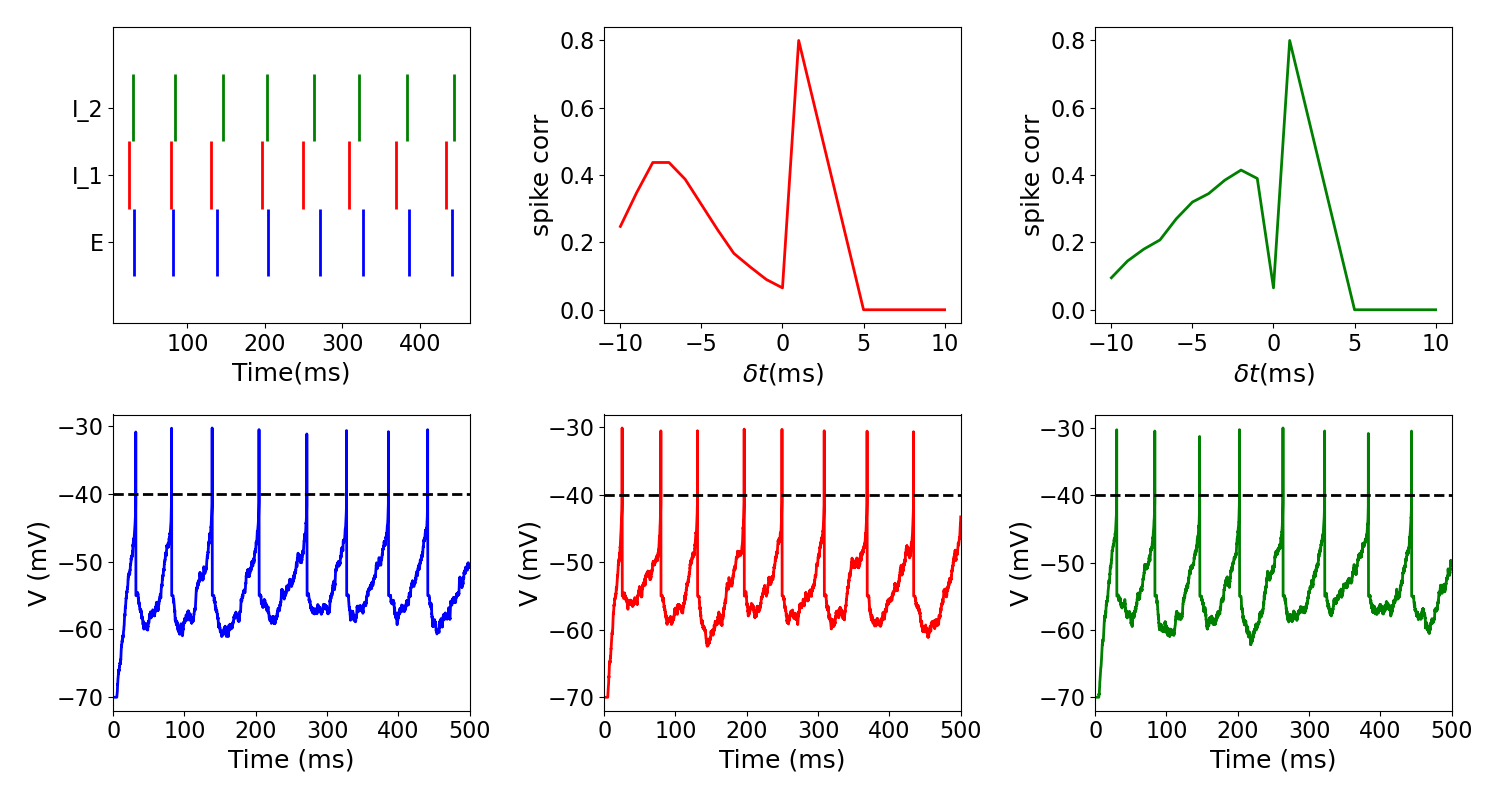

In [51]:
# Triplet
N = 3                  # number of neurons
wt, dl = 1., 5.

# updating parameters
def update(J_1=0., J_2=0., J_21=0.):
    # simualtor
    h = Simulator(dt=dt)

    # network of neurons
    nrns = [LIF(sim=h) for _ in range(N)]
    for nrn in nrns:
        # my own neuron
        nrn.update(my_neuron)

    # background noise
    # noises = [Current_injector(sim=h, Is=np.concatenate([np.zeros(int(T/dt*0.1)), rt*np.ones(int(T/dt*0.9))])) for _ in range(N)]
    noises = [Gaussian_generator(sim=h, mean=rt, std=rt) for _ in range(N)]
    # noises = [Poisson_generator(sim=h, rate=250) for _ in range(N)]
    for noise, nrn in zip(noises, nrns):
        nrn.connect(noise, {'ctype':'static', 'weight':wt, 'delay':dl})

    # recurrent connections
    # tps = [['facilitate']*N]*N
    tps = [['static']*N]*N
    con = np.array([[0., J_1, J_2],
                    [0., 0., 0.],
                    [0., J_21, 0.]])
    dly = np.random.uniform(2., 5., (N,N))
    synspecs = [[{} for _ in range(N)] for _ in range(N)]
    for i in range(N):
        for j in range(N):
            synspecs[i][j] = {'ctype':tps[i][j], 'weight':con[i,j], 'delay':dly[i,j]}
    h.connect(nrns, nrns, synspecs)

    # simulation
    h.run(T)

    # coincidence
    binwindow = int(5.0/dt)
    spike_trains = [nrn.states for nrn in nrns]
    bin_spikes = [np.convolve(strain, np.ones(binwindow), 'same') for strain in spike_trains]
    deltats = np.linspace(-10., 10., 21)
    coins_all = []
    for src, tar in zip([0, 0], [1, 2]):
        coins = []
        for delay in deltats:
            index = int(delay/dt)
            if index > 0:
                coins.append(np.dot(bin_spikes[src][:-index], bin_spikes[src][index:]))
            elif index < 0:
                coins.append(np.dot(bin_spikes[tar][:index], bin_spikes[src][-index:]))
            else:
                coins.append(np.dot(bin_spikes[0], bin_spikes[1]))
        coins = np.array(coins)/np.sqrt(np.dot(bin_spikes[0], bin_spikes[0]))/np.sqrt(np.dot(bin_spikes[1], bin_spikes[1]))
        coins_all.append(coins)

    # visualize
    plt.clf()
    cs = ['b', 'r', 'g']  
    plt.subplot(2,N,1)
    for nrn, c, l in zip(nrns,cs, range(N)):
        plt.eventplot(nrn.spikes['times'], lineoffsets=l, colors=c)
    plt.xlabel('Time(ms)')
    plt.yticks(range(N), ['E', 'I_1', 'I_2'])

    # rate plots of population
    plt.subplot(2,N,2)
    plt.plot(deltats, coins_all[0], 'r')
    plt.xlabel(r'$\delta t$(ms)')
    plt.ylabel('spike corr')

    plt.subplot(2,N,3)
    plt.plot(deltats, coins_all[1], 'g')
    plt.xlabel(r'$\delta t$(ms)')
    plt.ylabel('spike corr')

    # voltage trace
    for id, c in zip(range(N), cs):
        plt.subplot(2,N,id+N+1)
        plt_par = {'dt':dt, 'range_t':np.arange(0., T, dt), 'V_th':nrns[id].V_th}
        plot_volt_trace(plt_par, nrns[id].v, np.array(nrns[id].spikes['times']), c=c)
        plt.xlim([0., T])

    plt.tight_layout()

plt.subplots(2, N,figsize=(5*N,8))
widgets.interact(update, J_1=(-50., 0., 10), J_2=(-50., 0., 10), J_21=(-50., 0., 10));